In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Simple Linear Regression

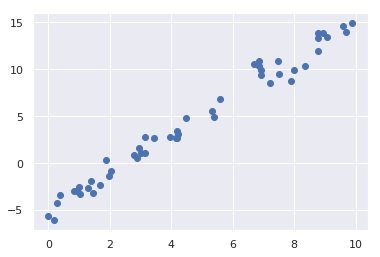

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

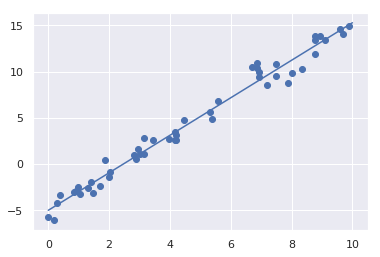

In [3]:
#Fitting data
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The model fit parameters are always marked with a trailing underscore. 

In [4]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.027208810360695
Model intercept: -4.998577085553202


### Polynomial Projection

We can adapt linear regression to non-linear relationships by transforming data to higher dimension polynomial features. 

Notice that this is still a linear model—the linearity refers to the fact that the coefficients never multiply or divide each other. What we have effectively done is taken our one-dimensional x values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between x and y.

In the example below, we have created a x2 column and a x3 column

In [5]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

#### Example: Creating a 7th degree polynomial model

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

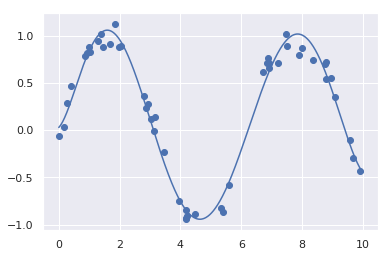

In [8]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

#### Example: Gaussian Basis Functions

We can fit a model that is not a sum of polynomial bases, but a sum of Gaussian (Normal Distribution) bases. 

Since these Gaussian functions are not built into Scikit learn, we will write a custom transformer to create them. 


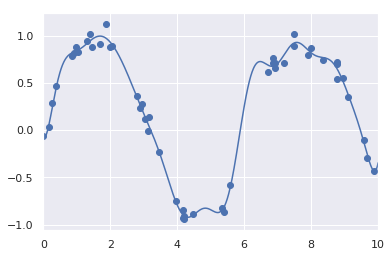

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

### Regularization

Higher order polynomial functions can potentially lead to overfitting. 

#### Example: Too many Gaussian Dimensions

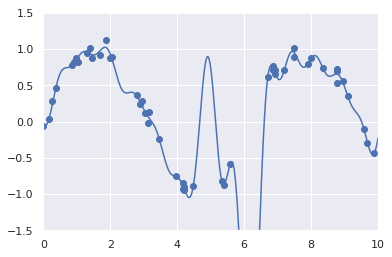

In [10]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

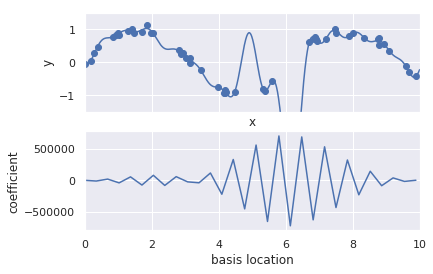

In [11]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

We can see typical overfitting behavior at the lower panel of the figure. The coefficients of the basis function blow up and cancel each other out. We want to limit such spikes by penalizing large values of the model parameters. This is known as regularization. 

#### Ridge Regression (L2 Regularization)

This works by penalizing the sum of squares of model coefficients. The alpha parameter controls the strength of the penalty. 

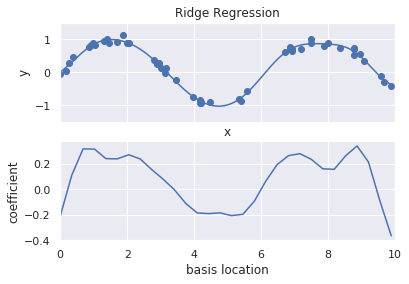

In [13]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

#### Lasso Regression (L1 Regression)

This involves penalizing the sum of absolute values of the regression coefficients. 

Lasso Regression tends to favour sparse models: it preferentially sets model coefficients to exactly zero. 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


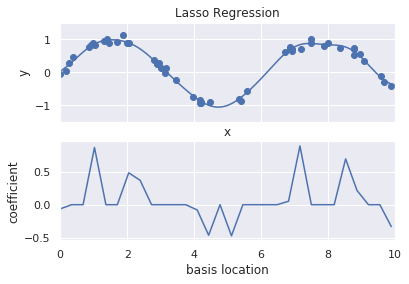

In [14]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

### Worked Example: Prediciting Bicycle Traffic

We will predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season and other factors. 

In [16]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2002k    0 2002k    0     0   826k      0 --:--:--  0:00:02 --:--:--  826k


In [19]:
# The code was removed by Watson Studio for sharing.

In [20]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv(body, index_col='DATE', parse_dates=True)

compute the total daily bicycle traffic, and put this in its own dataframe:

In [21]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

adding binary columns that indicate the day of the week:

In [22]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

(8, 17)

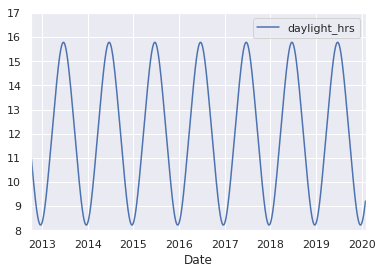

In [24]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

Add the average temperature and total precipitation to the data. 

We will also add a flag that indicates whether a day is dry (has zero precipitation).

In [25]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

add a counter that increases from day 1, and measures how many years have passed. This will let us measure any observed annual increase or decrease in daily crossings:

In [26]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [27]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1,0.010959


Fit a linear Regression model to our data. 

We will set `fit_intercept = False`, because the daily flags essentially operate as their own day-specific intercepts:

In [28]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Compare total and predicted bicycle traffic

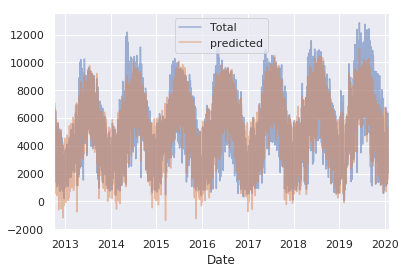

In [29]:
daily[['Total', 'predicted']].plot(alpha=0.5);

It appears that we have missed some key features, especially during summer time. 

we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [30]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              -1914.241244
Tue              -1523.697506
Wed              -1579.577855
Thu              -1844.571035
Fri              -2497.195667
Sat              -5285.387962
Sun              -5463.141654
holiday          -2222.869727
daylight_hrs       213.667666
PRCP           -340885.532232
dry day           1033.676212
Temp (C)           897.919247
annual             148.597263
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty. We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [31]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [32]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

                effect    error
Mon            -1914.0    142.0
Tue            -1524.0    144.0
Wed            -1580.0    141.0
Thu            -1845.0    143.0
Fri            -2497.0    135.0
Sat            -5285.0    135.0
Sun            -5463.0    139.0
holiday        -2223.0    301.0
daylight_hrs     214.0     14.0
PRCP         -340886.0  23471.0
dry day         1034.0     52.0
Temp (C)         898.0     36.0
annual           149.0     11.0


We can see that there are more riders on weekdays than on weekends and public holidays. 

For each additional hour of daylight, 214 more people choose to bike. 

A dry day means 1034 addtional people choose to bike. 

Precipitation seems to have a large effect on people choosing not to bike. 

We also see an increase of 149 riders per year. 